In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes, facet_grid, labs, geom_point, geom_smooth, coord_flip, scale_color_manual
from sklearn.linear_model import LinearRegression as lm
import statsmodels.tools.tools as sm
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
import requests
import os
import glob
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)
import seaborn as sns

In [2]:
#load the district files into a single dataframe
dist_path = "/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/clean_data/full_districts"
all_files = sorted(glob.glob(dist_path + "/*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

districts = pd.concat(li, axis=0, ignore_index=False)

In [3]:
#cut out anticipated maps 
districts = districts[districts["ST"].str[-1] != ")"]
districts.shape

(4350, 9)

In [4]:
districts.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/district_data.csv", index = False)

In [5]:
districts = districts[districts["year"] != 2022]

In [6]:
#confirm we have data from 9 Congressional Cycles
districts.shape[0] / 435

9.0

In [7]:
red = [2010,2014]
blu = [2006,2008,2018]
districts["wave"] = "Neutral"
districts["wave"] = np.where(districts["year"].isin(red), 'Red', districts["wave"])
districts["wave"] = np.where(districts["year"].isin(blu), 'Blue', districts["wave"])

## First, Recreate in the Binned Model from Previous Work

In [8]:
#split the dataframe into the smoothed bins
districts["bin"] = pd.cut(districts['metric'], 
    [0, .24, .42, .44, .45, .46, .47, .48, .49, .5,
        .51, .52, .53, .54, .57, .7, 1],
    labels=["D+26+","D+25 to D+8","D+7 to D+6","D+5","D+4","D+3","D+2","D+1",
        "EVEN","R+1","R+2","R+3","R+4","R+5 to R+7","R+8 to R+20","R+21+"])

In [9]:
def agg_probs_bin(df):
    '''Aggregate probailites of GOP represenation by bin
    Args:
        a datdistricts with historical election results
    Returns:
        a dataframe aggregating the probabilities of GOP representation
    '''
    sort = df.groupby("bin").mean()
    sort = sort.sort_values(by="metric")
    return pd.DataFrame(sort.is_GOP).reset_index().rename(columns={"is_GOP":"prob_GOP"})

In [10]:
#aggregate probabilites of historical data
prob_gop_bin = agg_probs_bin(districts)

In [11]:
prob_gop_bin

,bin,prob_GOP
0,D+26+,0.000000
1,D+25 to D+8,0.004449
2,D+7 to D+6,0.044586
3,D+5,0.117647
4,D+4,0.187500
5,D+3,0.253521
6,D+2,0.338710
7,D+1,0.370968
8,EVEN,0.402439
9,R+1,0.591837


In [12]:
#load in the conversion datafile for binned data
converter = pd.read_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/metric_converter.csv")

In [13]:
#add in rows to even the distribution 
d = {'metric' : [.85, .86, .87, .88, .89, .9, .91, .92, .93, .94]}
add = pd.DataFrame(data=d)
add["pvi_range"] = "R+21+"
add["prob_GOP"] = 1
converter = pd.concat([converter, add])

In [14]:
#clarify that the estimates are from binned
converter.columns = ["metric","pvi_range","prob_GOP_bin"]

## Next, include raw metrics just for comparison

In [15]:
def agg_probs(df):
    '''Aggregate probailites of GOP represenation by metric
    Args:
        a datdistricts with historical election results
    Returns:
        a dataframe aggregating the probabilities of GOP representation
    '''
    sort = df.groupby("metric").mean()
    sort = sort.sort_values(by="metric")
    return pd.DataFrame(sort.is_GOP).reset_index().rename(columns={"is_GOP":"prob_GOP_all"})

In [16]:
#aggregate probabilites of historical data
prob_gops_metric = agg_probs(districts)
#aggregate on wave years
prob_gops_red = agg_probs(districts[districts["wave"] == "Red"])
prob_gops_blue = agg_probs(districts[districts["wave"] == "Blue"])
#rename columns
prob_gops_red = prob_gops_red.rename(columns={"prob_GOP_all":"prob_GOP_red"})
prob_gops_blue = prob_gops_blue.rename(columns={"prob_GOP_all":"prob_GOP_blue"})
#attach associated probabilities
converter = pd.merge(converter,prob_gops_metric,how='left')
converter = pd.merge(converter,prob_gops_red,how='left')
converter = pd.merge(converter,prob_gops_blue,how='left')

In [17]:
#fill in blanks
converter[converter["metric"] < .25] = converter[converter["metric"] < .25].fillna(0)
converter[converter["metric"] > .75] = converter[converter["metric"] > .75].fillna(1)

In [18]:
converter.head()

,metric,pvi_range,prob_GOP_bin,prob_GOP_all,prob_GOP_red,prob_GOP_blue
0,0.06,D+26+,0.0,0.0,0.0,0.0
1,0.07,D+26+,0.0,0.0,0.0,0.0
2,0.08,D+26+,0.0,0.0,0.0,0.0
3,0.09,D+26+,0.0,0.0,0.0,0.0
4,0.10,D+26+,0.0,0.0,0.0,0.0


Now the converter has numeric values for the binned groupings and raw probabilities for each type of wave

# Begin Smoothing Models

Becuase the bins still don't result in smooth relationships between pvi and representation, it's worth creating a smoothed model that will account for the regular variation

In [19]:
X = districts["metric"].to_numpy().reshape(-1, 1)
y = districts["is_GOP"]
X_test = converter["metric"].to_numpy().reshape(-1, 1)

In [20]:
#halt probit

#fit the model with probit
#model = Probit(y, sm.add_constant(X).astype(float))
#prob_mod = model.fit()
#pred_y = prob_mod.predict(sm.add_constant(X_test))
#converter["probit_all"] = pred_y.round(2)
#prob_mod.summary()

In [21]:
#fit the model with logit
model = Logit(y, sm.add_constant(X).astype(float))
log_mod = model.fit()
pred_y = log_mod.predict(sm.add_constant(X_test))
converter["logit_all"] = pred_y.round(4)
#log_mod.summary()

Optimization terminated successfully.
         Current function value: 0.245845
         Iterations 8


In [22]:
#repeat for red waves
df = districts[districts["wave"] == "Red"]
X = df["metric"].to_numpy().reshape(-1, 1)
y = df["is_GOP"]
X_test = converter["metric"].to_numpy().reshape(-1, 1)
#fit the model with logit
model = Logit(y, sm.add_constant(X).astype(float))
log_mod = model.fit()
pred_y = log_mod.predict(sm.add_constant(X_test))
converter["logit_red"] = pred_y.round(4)

Optimization terminated successfully.
         Current function value: 0.181792
         Iterations 9


In [23]:
#repeat for blue waves
df = districts[districts["wave"] == "Blue"]
X = df["metric"].to_numpy().reshape(-1, 1)
y = df["is_GOP"]
X_test = converter["metric"].to_numpy().reshape(-1, 1)
#fit the model with logit
model = Logit(y, sm.add_constant(X).astype(float))
log_mod = model.fit()
pred_y = log_mod.predict(sm.add_constant(X_test))
converter["logit_blue"] = pred_y.round(4)

Optimization terminated successfully.
         Current function value: 0.305067
         Iterations 8


In [24]:
converter

,metric,pvi_range,prob_GOP_bin,prob_GOP_all,prob_GOP_red,prob_GOP_blue,logit_all,logit_red,logit_blue
0,0.06,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
1,0.07,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
2,0.08,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
3,0.09,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
4,0.10,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
5,0.11,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
6,0.12,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
7,0.13,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
8,0.14,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0000
9,0.15,D+26+,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.0001


In [25]:
converter.to_csv("/Users/xavier/Desktop/DSPP/solo_projects/redistricting_project/processed/converter.csv", index = False)

In [26]:
#lengthen converter for graphs
avg_all = converter[["metric", "prob_GOP_all","logit_all"]]
avg_all.columns = ["metric", "mean_GOP", "pred_GOP"]
avg_all["type"] = "all"
avg_red = converter[["metric", "prob_GOP_red","logit_red"]]
avg_red.columns = ["metric", "mean_GOP", "pred_GOP"]
avg_red["type"] = "red"
avg_blue = converter[["metric", "prob_GOP_blue","logit_blue"]]
avg_blue.columns = ["metric", "mean_GOP", "pred_GOP"]
avg_blue["type"] = "blue"
long = pd.concat([avg_all,avg_red,avg_blue])

In [27]:
avg_all

,metric,mean_GOP,pred_GOP,type
0,0.06,0.000000,0.0000,all
1,0.07,0.000000,0.0000,all
2,0.08,0.000000,0.0000,all
3,0.09,0.000000,0.0000,all
4,0.10,0.000000,0.0000,all
5,0.11,0.000000,0.0000,all
6,0.12,0.000000,0.0000,all
7,0.13,0.000000,0.0000,all
8,0.14,0.000000,0.0000,all
9,0.15,0.000000,0.0000,all


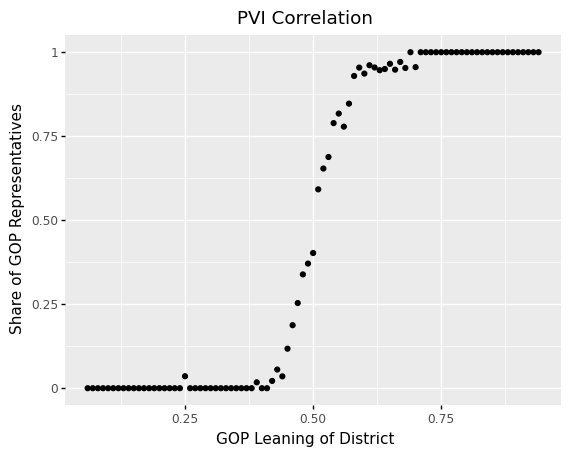

<ggplot: (8793077590279)>

In [28]:
#Plot averages for raw probabilities for all years
(p9.ggplot(data=converter, mapping=p9.aes(x='metric', y='prob_GOP_all'))
 + p9.geom_point() 
 + labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation"))

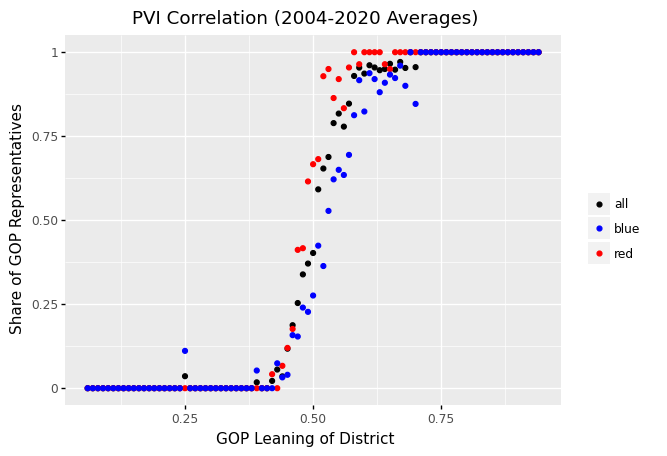

<ggplot: (8793077608418)>

In [29]:
#same plot but with gop and blue waves taken out
p9.ggplot(data=long, mapping=p9.aes(x='metric', y='mean_GOP')) + p9.geom_point(aes(color=long.type)) + scale_color_manual(values=("black", "blue", "red"))+ labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation (2004-2020 Averages)")# + coord_flip() 

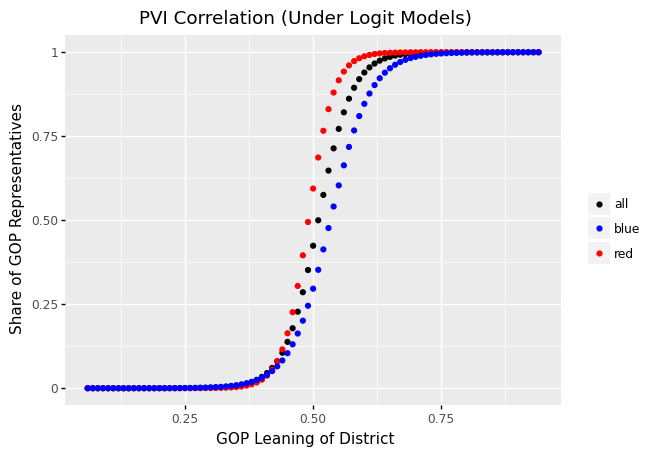

<ggplot: (8793079471330)>

In [30]:
#same plot but normalized
p9.ggplot(data=long, mapping=p9.aes(x='metric', y='pred_GOP')) + p9.geom_point(aes(color=long.type)) + scale_color_manual(values=("black", "blue", "red"))+ labs(x='GOP Leaning of District', y="Share of GOP Representatives",color="",title="PVI Correlation (Under Logit Models)")# + coord_flip()